### Import

In [2]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("classic")
%matplotlib inline
import seaborn as sns

### Retrieve data

In [4]:
# file

def read_file(user):
    if user=='nicola':
        dirname = '/Users/nicola/Desktop/Advanced Laboratory A/data/20220517/252Cf_CLYC_both_COINCIDENCE_CH4_1/FILTERED/'
    if user=='vittoria':
        dirname = '/mnt/c/Users/UTENTE/Downloads/252Cf_CLYC_both_COINCIDENCE_CH4_1/FILTERED/'
    if user == "javi":
        dirname = "/Volumes/javimarino/Padova/AdvancedLab/data/20220524/"
    filename_ch0 = dirname + 'ch0_coincidence_20220524.pkl'
    filename_ch2 = dirname + 'ch2_coincidence_20220524.pkl'
    filename_ch4 = dirname + 'ch4_coincidence_20220524.pkl'
    return filename_ch0, filename_ch2

filename_ch0, filename_ch2 = read_file('javi')

# retain data
print('Creating DataFrame 1/3...\n')
df0 = pd.read_pickle(filename_ch0)
print('Creating DataFrame 2/3...\n')
df2 = pd.read_pickle(filename_ch2)
print('Creating DataFrame 3/3...\n')
df4 = pd.read_pickle(filename_ch2)

# reset index because pickle data is not well formatted
df0.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
print('Dataset retrieved!')

Creating DataFrames...



KeyboardInterrupt: 

### Calculation of the PSA for both CLYCs (ch2 and ch4)

In [7]:
# function to get PSA from a dataframe
def getPSA(df, Nevent = 10000, nbaseline = 20, thr = 50, shortgate = 60, longgate = 250):

    '''
    parameters: df with the waveforms, Nevent is the total number of events to analyze,
    nbaseline is the number of samples where the baseline is calculated, thr is the 
    threshold value for starting the integration, qlong and qshort are the gates for the
    integration. The last two should not be modified
    '''

    psa = []

    #loop over the events
    for i in range(Nevent):
        # retrieve data
        waveform = np.array(df.iloc[i, 3:])

        # calculate baseline of the waveforms
        baseline = np.mean(waveform[3:nbaseline])

        # subtract baseline to waveforms
        waveform = waveform - baseline

        # calculation of starting point for integration
        start = 0
        for j in range(500):
            if waveform[j]>=thr and waveform[j+1]>=thr and waveform[j+2]>=thr and waveform[j+3]>=thr:
                aux = j
                start = aux
                break
            
        # calculation of qlong and qshort (from bin 50 on) for channel 2
        qlong, qshort = 0., 0.
        for j in np.arange(start, start+longgate):
            if j < start+shortgate : qshort += waveform[j]
            qlong += waveform[j]

        # calculation of PSA for channel 2
        aux_psa = (qlong - qshort) / qlong
        psa.append(aux_psa)

    return psa

In [8]:
nevents = 100

# retrieving the psa for the two detectors
psa_MI = getPSA(df2, nevents)
psa_PD = getPSA(df4, nevents)

In [1]:
# defining final dataframe for both CLYCs
df_MI = pd.DataFrame({ 'TIMETAG' : df0.iloc[:nevents, 0], 'Energy' : df0.iloc[:nevents, 1], 'PSA' : psa_MI })
df_PD = pd.DataFrame({ 'TIMETAG' : df2.iloc[:nevents, 0], 'Energy' : df2.iloc[:nevents, 1], 'PSA' : psa_PD })

NameError: name 'pd' is not defined

In [12]:
df_final = pd.concat([df_PD, df_MI], axis=1, join='inner')
df_final = df_final.drop('TIMETAG', 1)
df_final.columns = ['ENERGY_PD', 'PSA_PD', 'ENERGY_MI', 'PSA_MI']

/var/folders/nv/28ksfhj10wz9h413w7pr82sc0000gn/T/ipykernel_23818/4016755066.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_final = df_final.drop('TIMETAG', 1)


### Recognition of Gammas and Neutrons

In [13]:
# define energy thresholds and PSA cuts

# energy threshold
threshold_PD = 200
threshold_MI = 800

# gamma cuts
PSArange_gamma_PD = [0.55, 0.60]
PSArange_gamma_MI = [0.53, 0.58]

# neutron cuts
PSArange_neutron_PD = [0.60, 1]
PSArange_neutron_MI = [0.58, 1]

In [14]:
subth_mask = df_final[(df_final["ENERGY_PD"] < threshold_PD) | (df_final["ENERGY_MI"] < threshold_MI)].index
df_final.drop(subth_mask, inplace = True)


gamma_mask = df_final["PSA_PD"] < PSArange_gamma_PD[1]; neutron_mask = df_final["PSA_PD"] > PSArange_neutron_PD[0]
df_final.loc[gamma_mask, "pID_PD"] = "gamma"
df_final.loc[neutron_mask, "pID_PD"] = "neutron"

gamma_mask = df_final["PSA_MI"] < PSArange_gamma_PD[1]; neutron_mask = df_final["PSA_MI"] > PSArange_neutron_PD[0]
df_final.loc[gamma_mask, "pID_MI"] = "gamma"; df_final.loc[neutron_mask, "pID_MI"] = "neutron"

In [15]:
df_final

,ENERGY_PD,PSA_PD,ENERGY_MI,PSA_MI,pID_PD,pID_MI
66,258,0.570355,906,0.587653,gamma,gamma
95,565,0.580191,2105,0.597217,gamma,gamma
192,239,0.560541,944,0.585314,gamma,gamma
281,339,0.581747,1253,0.594419,gamma,gamma
286,396,0.553490,1651,0.585342,gamma,gamma
...,...,...,...,...,...,...
5817,587,0.585207,838,0.607210,gamma,neutron
5836,380,0.575987,1220,0.577558,gamma,gamma
5838,245,0.591213,1167,0.594738,gamma,gamma
5867,294,0.577443,2435,0.583032,gamma,gamma


### Gamma-gamma, gamma-neutron and neutron-Neutron coincidences

In [16]:
count_coincidences = df_final.groupby(['pID_PD', 'pID_MI']).size()
count_coincidences

pID_PD   pID_MI 
gamma    gamma      83
         neutron    40
neutron  gamma       8
         neutron     5
dtype: int64

### Graphics

(100.0, 3000.0)

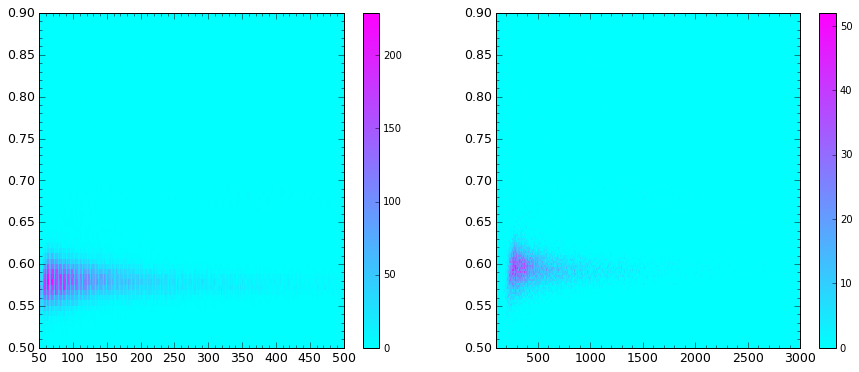

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6)); fig.patch.set_facecolor('xkcd:white')
for i in range(len(ax)):
    ax[i].tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
    ax[i].minorticks_on()
    ax[i].tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
    ax[i].tick_params(axis = 'both', labelsize = 12.5)
h2_PD = ax[0].hist2d(df_PD['Energy'], df_PD['PSA'], bins = (1000,1000), cmap = "cool") # afmhot, hot, gist_heat are others that work reasonably well
fig.colorbar(h2_PD[3], ax=ax[0])

h2_MI = ax[1].hist2d(df_MI['Energy'], df_MI['PSA'], bins = (1000,1000), cmap = "cool")
fig.colorbar(h2_MI[3], ax=ax[1])

for i in range(len(ax[:])):
    ax[i].set_ylim(0.5, 0.9)


ax[0].set_xlim(50., 500)
ax[1].set_xlim(100, 3000)

In [42]:
# correlated gamma energies
gg_energy = np.array(df_final["ENERGY_PD"][df_final[ (df_final["pID_PD"] == "gamma") & (df_final["pID_MI"] == "gamma") ].index]), np.array(df_final["ENERGY_MI"][df_final[ (df_final["pID_PD"] == "gamma") & (df_final["pID_MI"] == "gamma") ].index])

neutrons_energy = np.hstack((np.array(df_final["ENERGY_PD"][df_final[ (df_final["pID_PD"] == "neutron") & (df_final["pID_MI"] == "gamma") ].index]), np.array(df_final["ENERGY_MI"][df_final[ (df_final["pID_MI"] == "neutron") & (df_final["pID_PD"] == "gamma") ].index])))
gammas_energy = np.hstack((np.array(df_final["ENERGY_PD"][df_final[ (df_final["pID_PD"] == "gamma") & (df_final["pID_MI"] == "neutron") ].index]), np.array(df_final["ENERGY_MI"][df_final[ (df_final["pID_MI"] == "gamma") & (df_final["pID_PD"] == "neutron") ].index])))
ng_energy = [neutrons_energy, gammas_energy]

nn_energy = np.array(df_final["ENERGY_PD"][df_final[ (df_final["pID_PD"] == "neutron") & (df_final["pID_MI"] == "neutron") ].index]), np.array(df_final["ENERGY_MI"][df_final[ (df_final["pID_PD"] == "neutron") & (df_final["pID_MI"] == "neutron") ].index])

Text(0.5, 0.98, 'neutron-neutron correlation')

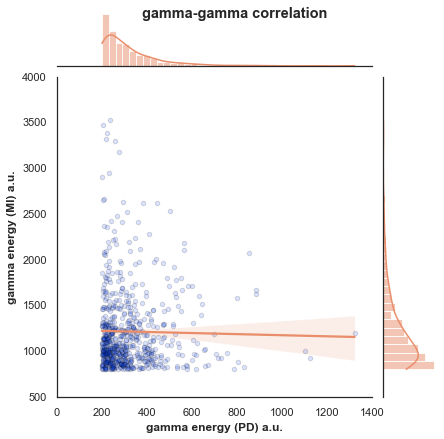

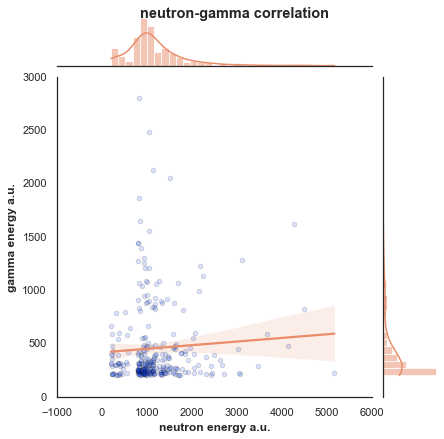

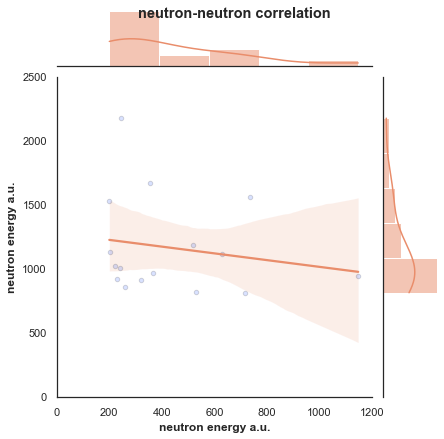

In [43]:
sns.set_theme(context = "notebook", style = "white", palette = "bright")
sns.set_palette("flare")

g = sns.jointplot(x = gg_energy[0], y = gg_energy[1], kind = "reg", scatter = False)
g.ax_joint.scatter(gg_energy[0], gg_energy[1], marker = "o", alpha = 0.15, edgecolors = "black")
g.ax_joint.set_xlabel("gamma energy (PD) a.u.", fontweight='bold')
g.ax_joint.set_ylabel("gamma energy (MI) a.u.", fontweight='bold')
g.fig.suptitle("gamma-gamma correlation", fontweight = "bold", fontsize = 14.5)

g = sns.jointplot(x = ng_energy[0], y = ng_energy[1], kind = "reg", scatter = False)
g.ax_joint.scatter(ng_energy[0], ng_energy[1], marker = "o", alpha = 0.15, edgecolors = "black")
g.ax_joint.set_xlabel("neutron energy a.u.", fontweight='bold')
g.ax_joint.set_ylabel("gamma energy a.u.", fontweight='bold')
g.fig.suptitle("neutron-gamma correlation", fontweight = "bold", fontsize = 14.5)


g = sns.jointplot(x = nn_energy[0], y = nn_energy[1], kind = "reg", scatter = False)
g.ax_joint.scatter(nn_energy[0], nn_energy[1], marker = "o", alpha = 0.15, edgecolors = "black")
g.ax_joint.set_xlabel("neutron energy a.u.", fontweight='bold')
g.ax_joint.set_ylabel("neutron energy a.u.", fontweight='bold')
g.fig.suptitle("neutron-neutron correlation", fontweight = "bold", fontsize = 14.5)